#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.index.is_monotonic

True

In [5]:
data = data.resample('1H').sum()

In [6]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

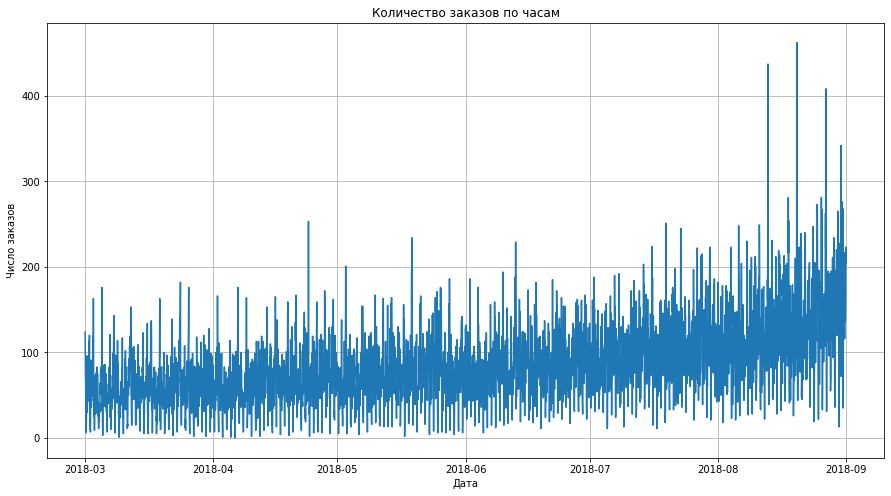

In [7]:
plt.figure(figsize=(15, 8))
plt.plot(data['num_orders'])
plt.title('Количество заказов по часам')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.grid(True)
plt.show()

Наблюдается рост среднего значения заказов, существуют редкие выбросы.

In [8]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [9]:
decomposed = seasonal_decompose(data)

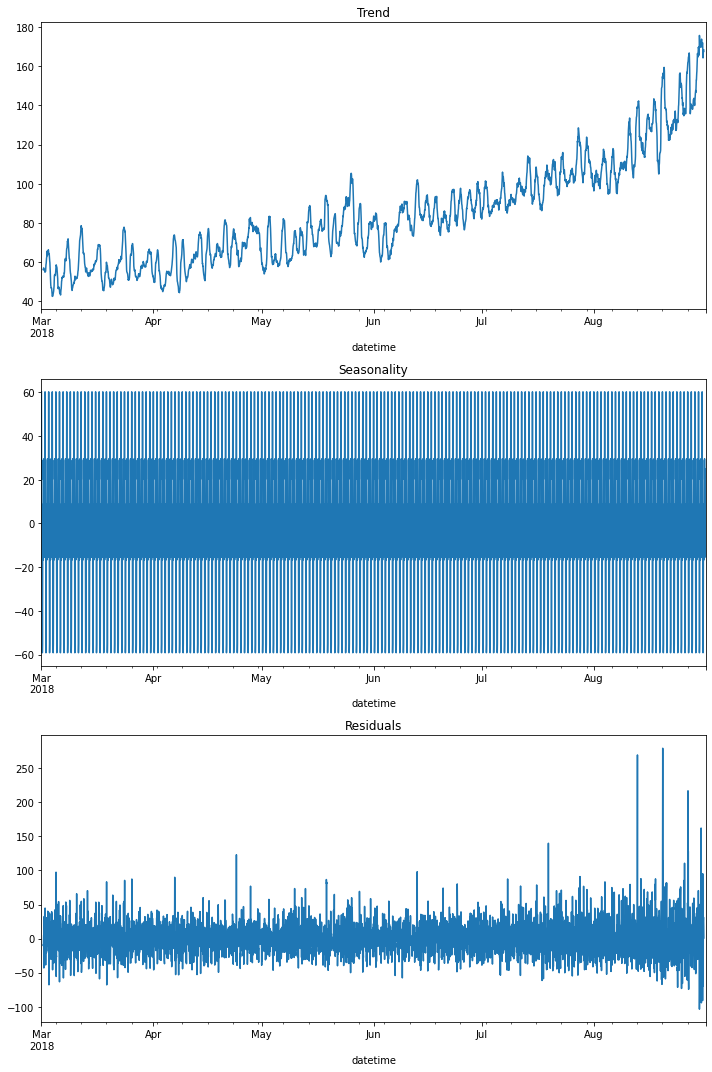

In [10]:
plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

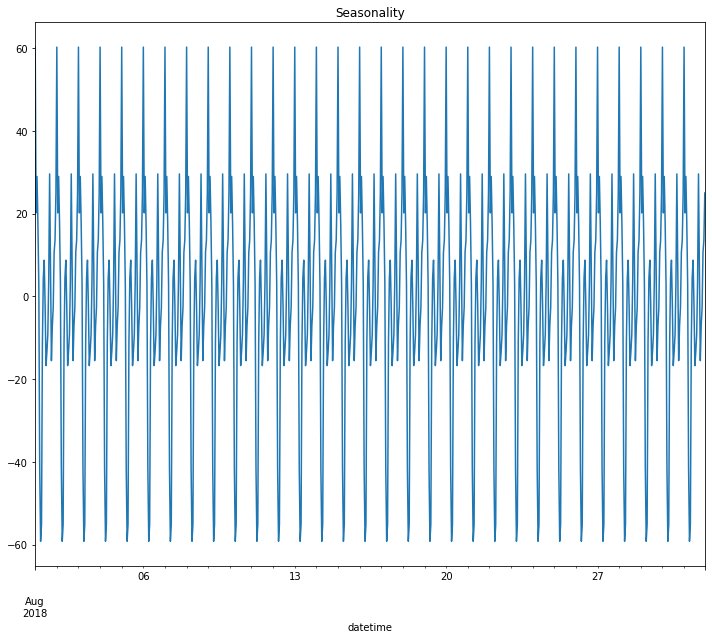

In [11]:
plt.figure(figsize=(12, 10))
decomposed.seasonal['2018-08': '2018-08'].plot(ax=plt.gca())
plt.title('Seasonality')

Линия тренда показывает рост количества заказов по месяцам.  
Наблюдается суточная сезонность, этоо видно по плотному и периодичному повторению значений, которые укладываются в равные интервалы.  
Остатки также имеют постоянной среднее значение, но иногда возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам).

## Обучение

### Подготовка данных

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 24, 48)

In [13]:
data.dropna(inplace=True)

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
X_train=train.drop('num_orders',axis=1)
y_train=train['num_orders']
X_test=test.drop('num_orders',axis=1)
y_test=test['num_orders']

### DecisionTreeRegressor

In [15]:
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
param_dist_dt = {
     'max_depth': range(3, 50),               
     'min_samples_split': range(2, 50),       
     'min_samples_leaf': range(1, 50)              
}

In [17]:
dt_model = DecisionTreeRegressor(random_state=71)

In [18]:
%%time
random_search_dt = RandomizedSearchCV(
    dt_model,
    param_dist_dt,
    n_iter=300, 
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=3,
    n_jobs=-1
)

random_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3] END max_depth=39, min_samples_leaf=46, min_samples_split=22;, score=-776.988 total time=   0.0s
[CV 2/3] END max_depth=39, min_samples_leaf=46, min_samples_split=22;, score=-769.769 total time=   0.0s
[CV 3/3] END max_depth=39, min_samples_leaf=46, min_samples_split=22;, score=-1290.131 total time=   0.0s
[CV 1/3] END max_depth=22, min_samples_leaf=16, min_samples_split=13;, score=-783.577 total time=   0.0s
[CV 2/3] END max_depth=22, min_samples_leaf=16, min_samples_split=13;, score=-814.865 total time=   0.0s
[CV 3/3] END max_depth=22, min_samples_leaf=16, min_samples_split=13;, score=-1239.253 total time=   0.0s
[CV 1/3] END max_depth=20, min_samples_leaf=29, min_samples_split=48;, score=-807.081 total time=   0.0s
[CV 2/3] END max_depth=20, min_samples_leaf=29, min_samples_split=48;, score=-783.605 total time=   0.0s
[CV 3/3] END max_depth=20, min_samples_leaf=29, min_samples_split=48;, score=-1215.280 total ti

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=71), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(3, 50),
                                        'min_samples_leaf': range(1, 50),
                                        'min_samples_split': range(2, 50)},
                   scoring='neg_mean_squared_error', verbose=3)

In [19]:
mse = -(random_search_dt.best_score_)
print('RMSE для DecisionTreeRegressor =', mse**0.5)

RMSE для DecisionTreeRegressor = 30.168569405701852


### LightGBM

In [20]:
lgb_model = LGBMRegressor(random_state=42)

In [21]:
param_dist_lgb = {
    'num_leaves': range(20, 50),
    'max_depth': range(3, 10),
    'learning_rate': [0.5, 0.1, 1]
}

In [22]:
random_search_lgb = RandomizedSearchCV(
    lgb_model,
    param_dist_lgb,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=10,
    random_state=42,
    n_jobs=-1
)

In [23]:
%%time
random_search_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START learning_rate=1, max_depth=5, num_leaves=37................
[CV 1/3; 1/50] END learning_rate=1, max_depth=5, num_leaves=37;, score=-954.328 total time=   0.4s
[CV 2/3; 1/50] START learning_rate=1, max_depth=5, num_leaves=37................
[CV 2/3; 1/50] END learning_rate=1, max_depth=5, num_leaves=37;, score=-1052.030 total time=   0.6s
[CV 3/3; 1/50] START learning_rate=1, max_depth=5, num_leaves=37................
[CV 3/3; 1/50] END learning_rate=1, max_depth=5, num_leaves=37;, score=-1441.710 total time=   0.7s
[CV 1/3; 2/50] START learning_rate=0.1, max_depth=4, num_leaves=24..............
[CV 1/3; 2/50] END learning_rate=0.1, max_depth=4, num_leaves=24;, score=-582.545 total time=   0.3s
[CV 2/3; 2/50] START learning_rate=0.1, max_depth=4, num_leaves=24..............
[CV 2/3; 2/50] END learning_rate=0.1, max_depth=4, num_leaves=24;, score=-569.434 total time=   0.5s
[CV 3/3; 2/50] START learning_ra

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.5, 0.1, 1],
                                        'max_depth': range(3, 10),
                                        'num_leaves': range(20, 50)},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=10)

In [24]:
mse = -(random_search_lgb.best_score_)
print('RMSE для LGBMRegressor =', mse**0.5)

RMSE для LGBMRegressor = 26.434478111079557


### RandomForestRegressor

In [25]:
rf_model = RandomForestRegressor(random_state=42, n_estimators = 50)

In [26]:
param_dist_rf = {
    'max_depth': range(3, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),

}

In [27]:
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_dist_rf,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=10
)

In [28]:
%%time
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3; 1/25] START max_depth=5, min_samples_leaf=10, min_samples_split=16.....
[CV 1/3; 1/25] END max_depth=5, min_samples_leaf=10, min_samples_split=16;, score=-686.447 total time=   0.4s
[CV 2/3; 1/25] START max_depth=5, min_samples_leaf=10, min_samples_split=16.....
[CV 2/3; 1/25] END max_depth=5, min_samples_leaf=10, min_samples_split=16;, score=-664.350 total time=   0.6s
[CV 3/3; 1/25] START max_depth=5, min_samples_leaf=10, min_samples_split=16.....
[CV 3/3; 1/25] END max_depth=5, min_samples_leaf=10, min_samples_split=16;, score=-1222.114 total time=   0.9s
[CV 1/3; 2/25] START max_depth=18, min_samples_leaf=15, min_samples_split=10....
[CV 1/3; 2/25] END max_depth=18, min_samples_leaf=15, min_samples_split=10;, score=-664.905 total time=   0.4s
[CV 2/3; 2/25] START max_depth=18, min_samples_leaf=15, min_samples_split=10....
[CV 2/3; 2/25] END max_depth=18, min_samples_leaf=15, min_samples_split=10;, score=-628.520 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(n_estimators=50,
                                                   random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 20),
                                        'min_samples_leaf': range(1, 20),
                                        'min_samples_split': range(2, 20)},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=10)

In [29]:
mse = -(random_search_rf.best_score_)
print('RMSE для RandomForestRegressor =', mse**0.5)

RMSE для RandomForestRegressor = 27.456935002952896


### LinearRegression

In [30]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
encoder = OneHotEncoder(drop='first', sparse_output=False)
cat_cols = ['hour', 'dayofweek']
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])
ohe_cols = encoder.get_feature_names_out(cat_cols)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)
X_train_lr.drop(columns=cat_cols, inplace=True)
X_test_lr.drop(columns=cat_cols, inplace=True)
X_train_lr = pd.concat([X_train_lr, X_train_ohe], axis=1)
X_test_lr = pd.concat([X_test_lr, X_test_ohe], axis=1)

In [31]:
lr_model = LinearRegression()
mse = cross_val_score(lr_model, X_train_lr, y_train, cv=tscv, scoring='neg_mean_squared_error')
print('RMSE для LinearRegression =',(-mse).mean()**0.5)

RMSE для LinearRegression = 26.198471541541004


## Тестирование

Результаты на тренировочных данных:  
LinearRegression = 26.19  
DecisionTreeRegressor = 30.23  
LightGBM = 26.43 
RandomForestRegressor = 27.45
Все модели справились с поставленной задачей(RMSE<=48), Лучшей стала LinearRegression, ее и будем проверить на тестовых данных.

In [33]:
lr_model.fit(X_train_lr,y_train)
y_pred_lr = lr_model.predict(X_test_lr)
print('RMSE на тестовой выборке для LinearRegression =', mean_squared_error(y_test, y_pred_lr)**0.5)

RMSE на тестовой выборке для LinearRegression = 41.53099433497102


В ходе работы были построены 4 модели и посчитаны их метрики RMSE на тренировочных данных с помощью кросс-валидации(LinearRegression = 26.19, DecisionTreeRegressor = 30.23, LightGBM = 26.43, RandomForestRegressor = 27.45). Лучшей была выбрана LinearRegression, она была протестирована на тестовых данных и показала результат RMSE=41.53, что удовлетворяет условие поставленной задачи(RMSE<=48). Так же в ходе анализа было выявлено, что количество заказов такси растет по месяцам, сезонность суточная, остатки также имеют постоянной среднее значение, но иногда возникают большие всплески.